<a href="https://colab.research.google.com/github/AnshSharma16/PicassoVision/blob/main/SKETCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Importing Required Libraries #

**os:** Helps in managing files and directories.

**tensorflow:** Used for machine learning and deep learning.

**numpy:** Provides support for multi-dimensional arrays and mathematical functions.

**PIL.Image:** Helps in opening, manipulating, and saving image files.

**time:** Useful for adding delays and measuring execution time.

**pickle:** Enables saving and loading trained models or datasets.

**functools:** Provides functions to optimize and enhance code performance.

**IPython.display:** Displays images and other media in a notebook environment.

**matplotlib.pyplot:** Helps in plotting graphs and visualizing data.

**google.colab.files:** Allows file uploads and downloads in Google Colab.

**cv2 (OpenCV):** Used for image and video processing tasks like reading, writing, and transforming images.

In [4]:
import os
import tensorflow as tf
import numpy as np
import PIL.Image
import time
import pickle
import functools
import IPython.display as display
from matplotlib import pyplot as plt
from google.colab import files
import cv2

# **Function: tensor_to_image**
This function converts a TensorFlow tensor into a PIL (Python Imaging Library) image, which is useful for visualizing deep-learning model outputs.


## **Scaling the Tensor:**
Tensor values are typically normalized between 0 and 1 in deep learning models.

This function scales the tensor values by multiplying them by 255 to match the pixel intensity range of standard images.

## **Converting to a NumPy Array:**
The tensor is transformed into a NumPy array with dtype=np.uint8 to ensure it holds valid pixel values (0-255).

## **Handling Multi-Dimensional Tensors:**
If the tensor has more than three dimensions, it is assumed to be in batch format (e.g., shape [1, height, width, channels]).
The function ensures that the first dimension (batch size) is 1 and removes it to get a standard image format ([height, width, channels]).

## **Creating a PIL Image:**
The NumPy array is converted into a PIL image using PIL.Image.fromarray() for easy manipulation and visualization.

In [ ]:
# Define functions for image loading and preprocessing
def tensor_to_image(tensor):
  """Converts a tensor to a PIL Image."""
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# **Function: load_img**
This function loads an image from a file path and converts it into a TensorFlow tensor while ensuring it is properly resized and normalized for deep learning applications.

## **Define Maximum Dimension (max_dim = 512):**
The image's longest side is resized to 512 pixels while maintaining the aspect ratio.
This prevents excessively large images that might slow down model training or inference.

## **Read the Image File (tf.io.read_file):**
The image is read from the specified file path as raw bytes.

## **Decode the Image (tf.image.decode_image):**
The raw bytes are converted into a 3-channel RGB image (ignoring any alpha/transparency channel).

## **Convert Image to Float Format (tf.image.convert_image_dtype):**
The pixel values are normalized to [0,1] range (from default 0-255 integer values).

## **Resize the Image while Maintaining Aspect Ratio:**
Obtain Original Shape: Extracts the height and width from the tensor.

## **Find Longest Dimension (long_dim):**
Determines whether the image is taller or wider.

## **Compute Scale Factor (scale = max_dim / long_dim):**
Ensures the image is resized proportionally.

##**Apply Scaling (tf.image.resize):**
Resizes the image while keeping its proportions intact.

##**Add a Batch Dimension (img = img[tf.newaxis, :]):**
Converts the image to batch format ([1, height, width, channels]), which is the standard input format for deep learning models.

In [5]:
def load_img(path_to_img):
  """Loads an image and converts it to a tensor."""
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


# **Function: create_pencil_sketch_style**
This function generates a dark pencil sketch-style effect from an input image using OpenCV and TensorFlow. It applies edge detection and thresholding techniques to simulate a hand-drawn pencil sketch.

## **Convert Tensor to NumPy Array:**
Extracts the first image from the batch (content_image[0]).
Converts pixel values from [0,1] range back to [0,255] format.
Converts the TensorFlow tensor to a NumPy array for OpenCV processing.

## **Convert to Grayscale (cv2.cvtColor):**
Converts the RGB image to a grayscale image for edge detection.

## **Apply Gaussian Blur (cv2.GaussianBlur):**
Blurs the grayscale image to reduce noise and create a smoother effect.

## **Detect Edges using Laplacian (cv2.Laplacian):**
Uses the Laplacian operator to detect edges in the blurred image.

## **Invert the Image (255 - edges):**
Inverts the colors so that edges appear white and the background is dark.

## **Enhance Edges using Thresholding (cv2.threshold):**
Highlights only the strongest edges, giving a sharp pencil-drawn effect.

## **Convert Back to RGB (cv2.cvtColor):**
Though still a grayscale image, it is converted to RGB format for compatibility with TensorFlow.

## **Convert Back to Tensor (tf.convert_to_tensor):**
Scales values back to [0,1] range.
Adds a batch dimension (tf.newaxis, :) to maintain consistency with deep learning models.



In [6]:
def create_pencil_sketch_style(content_image):
  """Creates a dark pencil sketch-style reference from the content image."""
  # Convert tensor to numpy array for OpenCV processing
  img = content_image[0].numpy()
  img = (img * 255).astype(np.uint8)

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # Apply Gaussian blur to reduce noise
  gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

  # Create edge detection using Laplacian
  edges = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=5)

  # Invert the image for pencil sketch effect
  inverted = 255 - edges

  # Apply threshold to make edges more prominent
  _, sketch = cv2.threshold(inverted, 180, 255, cv2.THRESH_BINARY)

  # Convert back to RGB (still grayscale in appearance)
  sketch_rgb = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)

  # Convert back to tensor format
  sketch_tensor = tf.convert_to_tensor(sketch_rgb, dtype=tf.float32) / 255.0
  sketch_tensor = sketch_tensor[tf.newaxis, :]

  return sketch_tensor

# **Function: imshow**
This function displays an image using Matplotlib and supports an optional title.

## **Handle Extra Dimensions (tf.squeeze):**
If the image has more than 3 dimensions (e.g., batch dimension), it removes extra dimensions using tf.squeeze().
This ensures proper visualization of the image.

## **Set Figure Size (plt.figure):**
Creates a 10x10-inch figure for better visibility.

## **Display Image (plt.imshow):**
Uses Matplotlib to display the image.

## **Add Title (Optional):**
If a title is provided, it is added using plt.title(title).

## **Remove Axes (plt.axis('off')):**
Removes axis labels and grid lines for a clean display.

## **Show the Image (plt.show()):**
Displays the final output.

In [7]:
def imshow(image, title=None):
  """Displays an image with an optional title."""
  if len(image.shape) > 3:
    image = tf.squeeze(image)

  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  if title:
    plt.title(title)
  plt.axis('off')
  plt.show()

# **Function: vgg_layers**
This function creates a VGG19 model that extracts intermediate feature maps from specific layers, useful for neural style transfer.

## Load Pretrained VGG19 (tf.keras.applications.VGG19)
Loads the VGG19 model without the top classification layers (include_top=False).
Uses pretrained ImageNet weights for feature extraction.

## **Freeze the Model (vgg.trainable = False):**
Prevents updating the VGG19 weights during training (keeps it static as a feature extractor).

## **Select Specific Layers (vgg.get_layer(name).output):**
Extracts the feature maps from specified layers.
These layers capture different levels of texture and style information.

## **Create a New Model (tf.keras.Model):**
Defines a custom model that takes the original VGG19 input and outputs the selected intermediate layers.

This allows us to access the content and style representations from the image.

In [8]:
# Define style transfer model
def vgg_layers(layer_names):
  """Creates a VGG model that returns a list of intermediate output values."""
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

# **Function: gram_matrix**
This function calculates the Gram matrix, which is used in style transfer to capture texture patterns from an image.

## **Compute the Outer Product (tf.linalg.einsum)**
The formula **tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)** performs a dot product of the feature maps.
This measures how much the different channels (features) correlate with each other.

## Normalize by the Number of Locations
The Gram matrix is divided by the total number of pixel locations (num_locations = height * width).
This ensures that the style representation is scale-invariant (i.e., independent of image size).




In [9]:
def gram_matrix(input_tensor):
  """Calculate the Gram matrix of an input tensor."""
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


In [10]:
def clip_0_1(image):
  """Clips image tensor values to between 0 and 1."""
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


# **Function: style_content_loss**
# This function calculates the total loss for neural style transfer by combining both style loss and content loss.

In neural style transfer, an input image is optimized to resemble a content image while also incorporating stylistic elements from a reference style image. This function computes:

## Style Loss:
Measures the difference between the extracted style features (Gram matrices) of the generated image and the target style image.

## Content Loss:
Measures the difference between the extracted content features of the generated image and the original content image.

##outputs (dict) –
A dictionary containing feature maps of the generated image:

##outputs['style'] –
Extracted style features.

##outputs['content'] –
Extracted content features.

##style_targets (dict) –
A dictionary containing extracted style features from the target style image.

##content_targets (dict) –
A dictionary containing extracted content features from the target content image.

##style_weight (float) –
A scaling factor determining the influence of style loss.

##content_weight (float) –
A scaling factor determining the influence of content loss.

##Style Loss Calculation:
Computes the Mean Squared Error (MSE) between extracted style features of the generated image and the target style image.
The loss is normalized by the number of style layers.

##Content Loss Calculation:
Computes the Mean Squared Error (MSE) between extracted content features of the generated image and the target content image.
The loss is normalized by the number of content layers.

##Total Loss Calculation:
The final loss is the weighted sum of style and content losses.

In [11]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight):
  """Calculate the total style and content loss."""
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                          for name in style_outputs.keys()])
  style_loss *= style_weight / len(style_outputs)

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
  content_loss *= content_weight / len(content_outputs)
  total_loss = style_loss + content_loss
  return total_loss

# **Function: train_step**
This function performs a single training step for updating the generated image in a Neural Style Transfer (NST) model. It optimizes the image to minimize the style-content loss while maintaining image smoothness.

The function takes an image and iteratively refines it by computing gradients and applying them using an optimizer.

In [12]:
@tf.function()
def train_step(image, style_targets, content_targets, optimizer, style_weight, content_weight, extractor):
  """Update the target image."""
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight)
    loss += tf.image.total_variation(image) * 30

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

# **Function: to_dark_pencil_sketch**
This function enhances a generated image by converting it into a dark pencil sketch effect, simulating hand-drawn strokes with improved contrast, texture, and realism.



In [13]:
# Enhanced pencil sketch post-processing
def to_dark_pencil_sketch(image_tensor):
  """Convert the final output to a darker, more realistic pencil sketch."""
  # Convert tensor to numpy array
  img = image_tensor[0].numpy()
  img = (img * 255).astype(np.uint8)

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # Apply adaptive thresholding to create stronger line effect
  # This creates more detailed texture similar to pencil strokes
  adaptive_threshold = cv2.adaptiveThreshold(
      gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv2.THRESH_BINARY, 11, 2
  )

  # Invert to get the black lines on white paper effect
  inverted_sketch = 255 - adaptive_threshold

  # Enhance contrast
  _, enhanced_sketch = cv2.threshold(inverted_sketch, 150, 255, cv2.THRESH_BINARY)

  # Blur slightly to soften the sketch and make it more natural
  sketch_blurred = cv2.GaussianBlur(enhanced_sketch, (3, 3), 0)

  # Convert back to RGB (still grayscale in appearance)
  sketch_rgb = cv2.cvtColor(sketch_blurred, cv2.COLOR_GRAY2RGB)

  # Convert back to tensor format
  final_sketch = tf.convert_to_tensor(sketch_rgb, dtype=tf.float32) / 255.0
  final_sketch = final_sketch[tf.newaxis, :]

  return final_sketch

# **Function: to_pencil_dodge_burn**
This function applies the dodge and burn technique to create a highly realistic pencil sketch effect from an image. The technique is widely used in digital image processing to simulate fine pencil strokes.

In [14]:
# Alternative sketch style using dodge and burn technique
def to_pencil_dodge_burn(image_tensor):
  """Create a realistic pencil sketch using dodge and burn technique."""
  # Convert tensor to numpy array
  img = image_tensor[0].numpy()
  img = (img * 255).astype(np.uint8)

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # Invert the grayscale image
  inverted = 255 - gray

  # Apply Gaussian blur
  blur = cv2.GaussianBlur(inverted, (21, 21), 0)

  # Invert blurred image
  inverted_blur = 255 - blur

  # Divide gray by inverted blur image (dodge effect)
  pencil_sketch = cv2.divide(gray, inverted_blur, scale=256.0)

  # Enhance the sketch by adjusting contrast
  alpha = 1.5  # Contrast control (1.0-3.0)
  beta = 10    # Brightness control (0-100)
  enhanced_sketch = cv2.convertScaleAbs(pencil_sketch, alpha=alpha, beta=beta)

  # Make the sketch darker
  _, darker_sketch = cv2.threshold(enhanced_sketch, 160, 255, cv2.THRESH_BINARY)

  # Convert back to RGB (still grayscale in appearance)
  sketch_rgb = cv2.cvtColor(darker_sketch, cv2.COLOR_GRAY2RGB)

  # Convert back to tensor format
  final_sketch = tf.convert_to_tensor(sketch_rgb, dtype=tf.float32) / 255.0
  final_sketch = final_sketch[tf.newaxis, :]

  return final_sketch

In [15]:
class StyleContentModel(tf.keras.models.Model):
  """Model that extracts style and content features."""
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs): # Added the call function
    """Expects normalized inputs in range [0,1]"""
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [16]:
# Main neural style transfer function for sketch
def run_sketch_conversion(content_path, epochs=10, steps_per_epoch=100):
  """Run sketch conversion on the given content image."""
  content_image = load_img(content_path)
  style_image = create_pencil_sketch_style(content_image)

  # Display loaded images
  print("Original Image:")
  imshow(content_image[0], "Original Image")
  print("Pencil Sketch Style Reference:")
  imshow(style_image[0], "Pencil Sketch Style Reference")

  # Initialize model with emphasis on earlier layers for sketch effect
  content_layers = ['block4_conv2']
  style_layers = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1',
                  'block4_conv1']

  extractor = StyleContentModel(style_layers, content_layers)

  # Set targets
  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']

  # Initialize image to optimize
  image = tf.Variable(content_image)

  # Set optimization parameters - increase style weight for more sketch effect
  opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
  style_weight = 300  # Significantly increased for stronger sketch effect
  content_weight = 0.5  # Decreased to favor style over content

  # Run optimization
  start = time.time()

  for n in range(epochs):
    for m in range(steps_per_epoch):
      train_step(image, style_targets, content_targets, opt, style_weight, content_weight, extractor)

    print(f"Epoch {n+1}/{epochs}")
    if (n+1) % 2 == 0 or n == epochs-1:
      imshow(image.read_value()[0], f"Output after {n+1} epochs")

  end = time.time()
  print(f"Total time: {end-start:.1f} seconds")

  # Convert to final dark pencil sketch using multiple methods
  adaptive_sketch = to_dark_pencil_sketch(image.read_value())
  dodge_burn_sketch = to_pencil_dodge_burn(image.read_value())

  # Display final sketches
  print("Dark Pencil Sketch (Method 1):")
  imshow(adaptive_sketch[0], "Dark Pencil Sketch (Adaptive)")

  print("Dark Pencil Sketch (Method 2):")
  imshow(dodge_burn_sketch[0], "Dark Pencil Sketch (Dodge & Burn)")

  # Return all versions
  return (tensor_to_image(image.read_value()[0]),
          tensor_to_image(adaptive_sketch[0]),
          tensor_to_image(dodge_burn_sketch[0]))

Upload your image to convert to a dark pencil sketch:


Saving FB_IMG_1705900901193.jpg to FB_IMG_1705900901193.jpg
Running Dark Pencil Sketch Conversion (this may take a few minutes)...
Original Image:


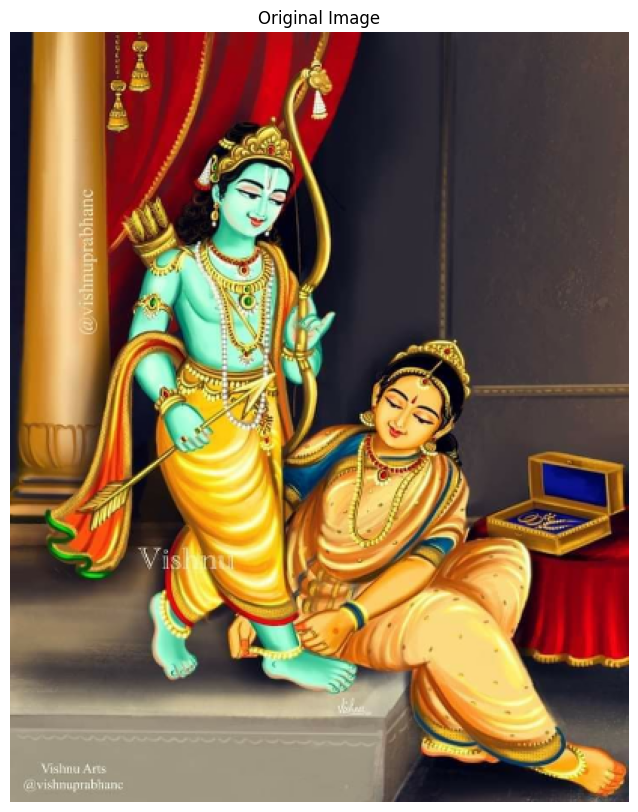

Pencil Sketch Style Reference:


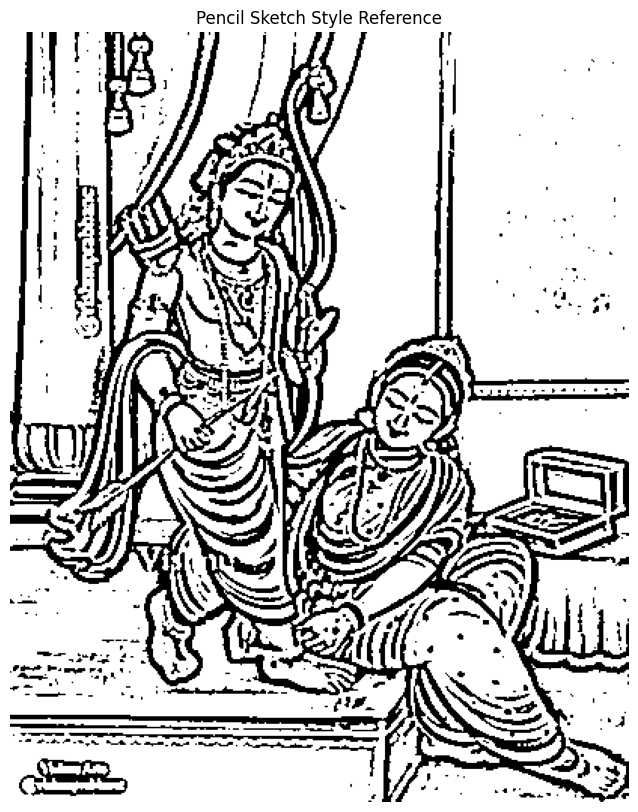

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 411, 3))
  warnings.warn(msg)


Epoch 1/10
Epoch 2/10


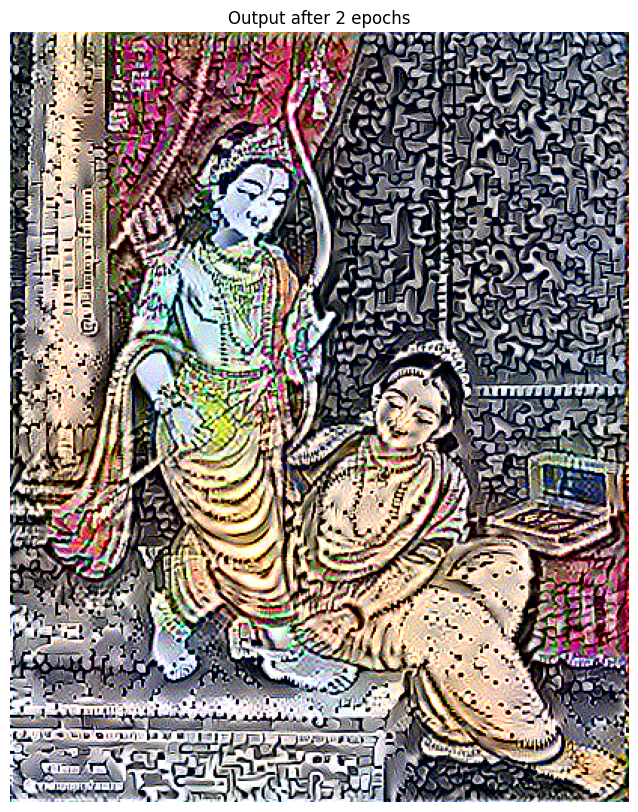

Epoch 3/10
Epoch 4/10


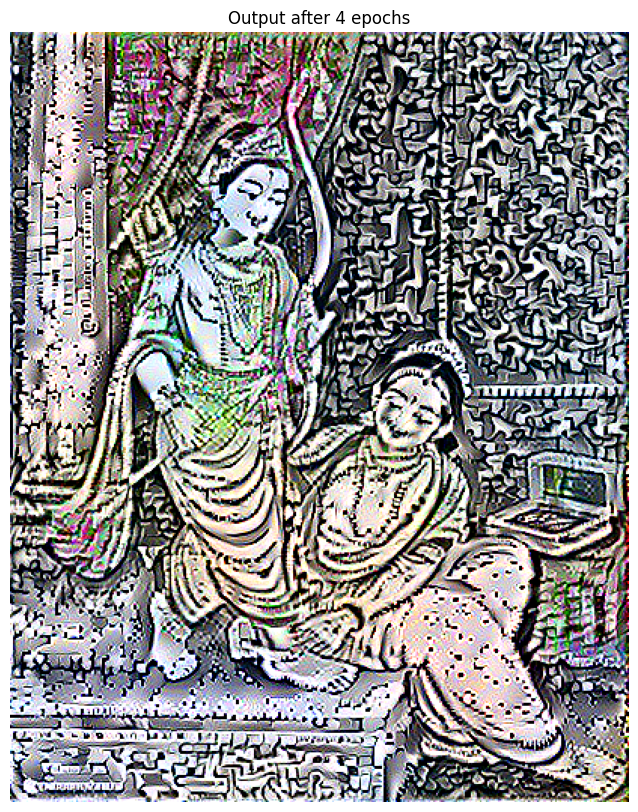

Epoch 5/10
Epoch 6/10


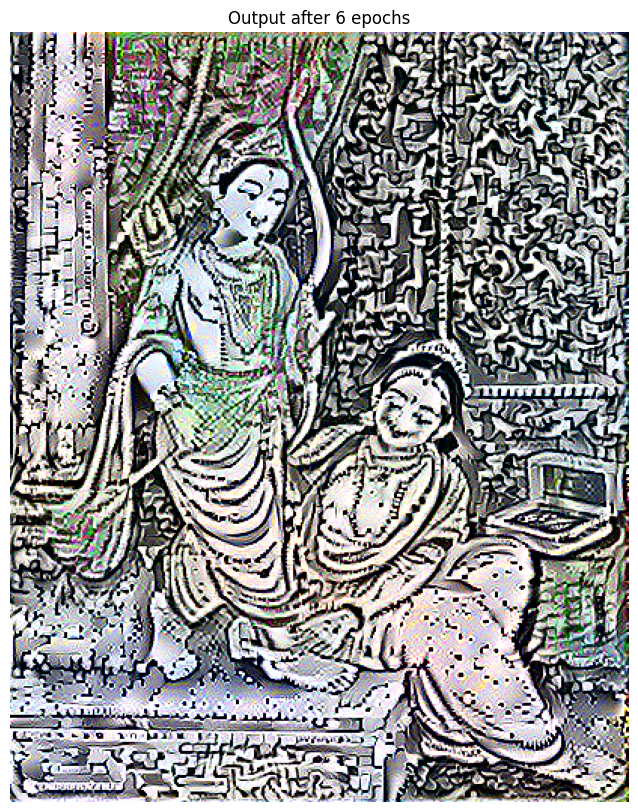

In [ ]:
# UI Part
print("Upload your image to convert to a dark pencil sketch:")
content_file = files.upload()
content_path = list(content_file.keys())[0]

print("Running Dark Pencil Sketch Conversion (this may take a few minutes)...")
styled_image, adaptive_sketch, dodge_burn_sketch = run_sketch_conversion(content_path, epochs=10, steps_per_epoch=50)

print("Final Results:")
print("1. Neural Style Transfer Result:")
display.display(styled_image)
print("2. Dark Pencil Sketch (Adaptive Method):")
display.display(adaptive_sketch)
print("3. Dark Pencil Sketch (Dodge & Burn Method):")
display.display(dodge_burn_sketch)

# Save and download the results
styled_image.save("styled_image.png")
adaptive_sketch.save("dark_pencil_sketch_1.png")
dodge_burn_sketch.save("dark_pencil_sketch_2.png")
files.download("styled_image.png")
files.download("dark_pencil_sketch_1.png")
files.download("dark_pencil_sketch_2.png")

In [ ]:
# New function to save model configuration
def save_model_configuration(content_layers, style_layers, style_weight, content_weight, epochs, steps_per_epoch):
    """Save the model configuration to a pickle file."""
    model_config = {
        'content_layers': content_layers,
        'style_layers': style_layers,
        'style_weight': style_weight,
        'content_weight': content_weight,
        'epochs': epochs,
        'steps_per_epoch': steps_per_epoch,
        'optimizer_params': {
            'learning_rate': 0.02,
            'beta_1': 0.99,
            'epsilon': 1e-1
        }
    }

    # Save the configuration
    with open('model.pkl', 'wb') as f:
        pickle.dump(model_config, f)

    print("Model configuration saved to model.pkl")
    files.download('model.pkl')

    return model_config



In [ ]:
from google.colab import files
files.download('model.pkl')
